# One Pixel Attack Tutorial

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

Let's get started.

## Imports

Ensure that you have numpy, pandas, scipy, matplotlib, and keras installed.

In [1]:
# Python Libraries
%matplotlib inline
import numpy as np
import pandas as pd
from keras.datasets import cifar10
from keras.models import load_model
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output
import pickle

# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from helper import plot_image, plot_images, evaluate_models, visualize_attack, attack_stats

matplotlib.style.use('ggplot')

Using TensorFlow backend.


## Load Dataset

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.datasets.cifar import load_batch
import keras.backend as K
import numpy as np
import os

def load_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    path = '/input/cifar-10/cifar-10-batches-py'
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

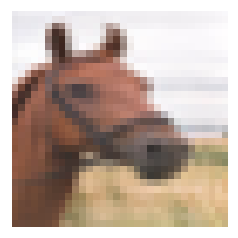

In [5]:
image = 99 # Image index in the test set
plot_image(x_test[image])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $\textbf{X}$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$.

In [6]:
def perturb_image(x, img):
    # Copy the image to keep the original unchanged
    img = np.copy(img) 
    
    # Split into an array of 5-tuples (perturbation pixels)
    # Make sure to floor the members of x as int types
    pixels = np.split(x.astype(int), len(x) // 5)
    
    # At each pixel's x,y position, assign its rgb value
    for pixel in pixels:
        x_pos, y_pos, *rgb = pixel
        img[x_pos, y_pos] = rgb
    return img

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

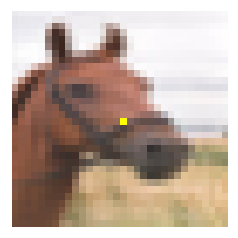

In [7]:
image = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image])

plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset.

It is recommended to use Keras with a GPU enabled. The code below can be used to check (if using TensorFlow).

In [8]:
# Should output /device:GPU:0

'''
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
'''

'\nfrom keras import backend as K\nK.tensorflow_backend._get_available_gpus()\n'

We will now load some pretrained models, which can be found in the `networks/models` directory. 

There are two models included in this repository, `lecun_net` and `resnet` which will be loaded automatically. Optionally, you may uncomment the lines below to download the larger, more accurate models (e.g., Capsule Network, DenseNet, etc.).

In [9]:
lecun_net = LecunNet()
resnet = ResNet()

models = [lecun_net, resnet]

## Uncomment below to download more models to play with

# lecun_net = LecunNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lecun_net
Successfully loaded resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [10]:
network_stats, correct_imgs = evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lecun_net
Evaluating resnet


,name,accuracy,param_count
0,lecun_net,0.7488,62006
1,resnet,0.9231,470218


### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs a perturbed image on a given model and returns the model's confidence (probability output) in a target class. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [11]:
def predict_class(x, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    img_perturbed = perturb_image(x, img)
    prediction = model.predict_one(img_perturbed)[target_class]
    # This function should always be minimized, so return its complement if needed
    return prediction if minimize else 1 - prediction

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class bird is 0.000188874
Prior confidence was 0.706618


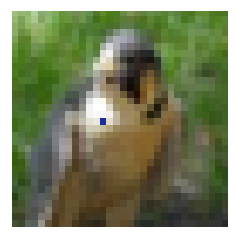

In [12]:
image = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image,0]
# prior_confidence = model.predict_one(x_test[image])[true_class]
prior_confidence = model.predict_one(x_test[image])[true_class]
confidence = predict_class(pixel, x_test[image], true_class, model)

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
plot_image(perturb_image(pixel, x_test[image]))

## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [13]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, x_test[img])

    confidence = model.predict_one(attack_image)
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if (verbose):
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.0746011
Prior confidence 0.500542
Attack success: True


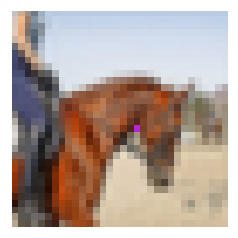

In [14]:
image = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image,0]
prior_confidence = model.predict_one(x_test[image])[true_class]
success = attack_success(pixel, image, true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
plot_image(perturb_image(pixel, x_test[image]))

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be spiky.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function):

<br>

![Ackley GIF](images/Ackley.gif)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html). For demonstration purposes it's more than sufficient (however, it can be optimized further).


In [15]:
def attack(img, model, target=None, pixel_count=1, 
           maxiter=30, popsize=30, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img,0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda x: predict_class(
        x, x_test[img], target_class, model, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=max(1, popsize // pixel_count),
        recombination=1, atol=-1, callback=callback_fn)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img])
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img,0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_image]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

Confidence: 0.984905
Confidence: 0.984905
Confidence: 0.832639
Confidence: 0.38815


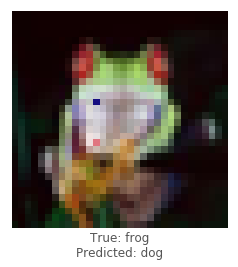

In [16]:
image = 102
pixels = 2 # Number of pixels to attack
model = resnet

_ = attack(image, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lecun_net` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

Attacking with target automobile
Confidence: 0.049818
Confidence: 0.049818
Confidence: 0.049818
Confidence: 0.049818
Confidence: 0.049818
Confidence: 0.049818
Confidence: 0.0722031
Confidence: 0.148195
Confidence: 0.148195
Confidence: 0.158325
Confidence: 0.16774
Confidence: 0.383951
Confidence: 0.383951
Confidence: 0.456346
Confidence: 0.886512


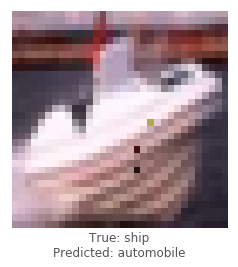

In [17]:
image = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lecun_net

print('Attacking with target', class_names[target_class])
_ = attack(image, model, target_class, pixel_count=pixels, popsize=50, maxiter=40, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1-3 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [ ]:
def attack_all(models, samples=100, pixels=(1,2,3), targeted=False, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples)
        for pixel_count in pixels:
            for i,img in enumerate(img_samples):
                print(model.name, '- image', img, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if (targeted):
                        print('Attacking with target', class_names[target])
                        if (target == y_test[img,0]):
                            continue
                    result = attack(img, model, target, pixel_count, verbose=verbose)
                    model_results.append(result)
        results += model_results
    return results

lecun_net - image 9094 - 1 / 10


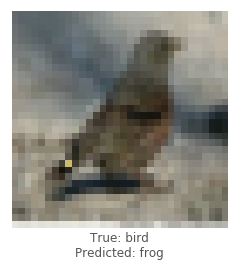

lecun_net - image 8744 - 2 / 10


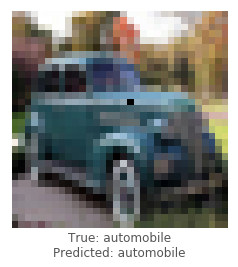

lecun_net - image 2040 - 3 / 10


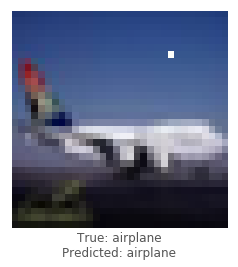

lecun_net - image 5111 - 4 / 10


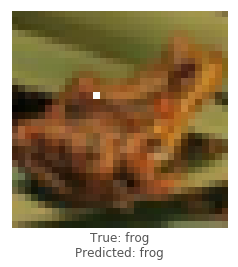

lecun_net - image 3105 - 5 / 10


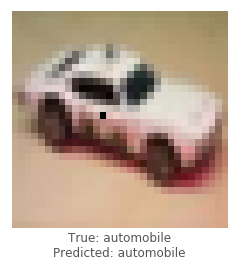

lecun_net - image 5348 - 6 / 10


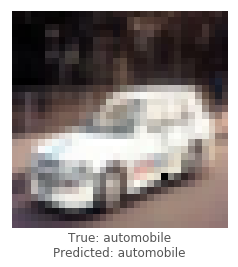

lecun_net - image 205 - 7 / 10


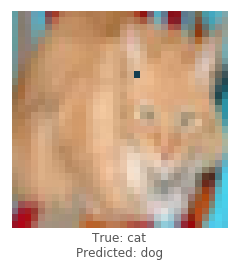

lecun_net - image 5028 - 8 / 10


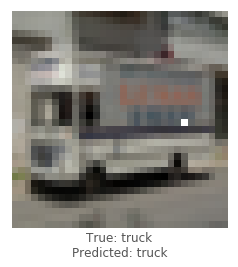

lecun_net - image 8615 - 9 / 10


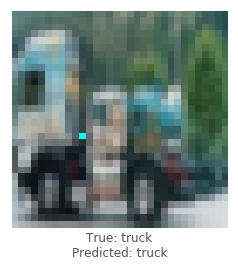

lecun_net - image 1303 - 10 / 10


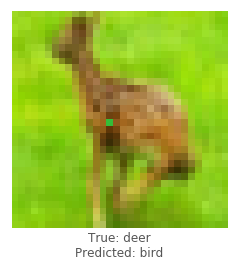

lecun_net - image 9094 - 1 / 10


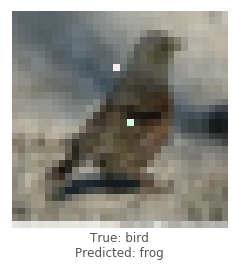

lecun_net - image 8744 - 2 / 10


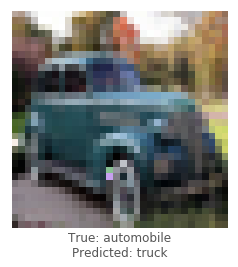

lecun_net - image 2040 - 3 / 10


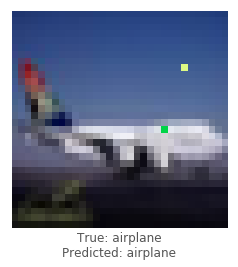

lecun_net - image 5111 - 4 / 10


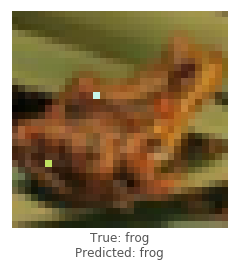

lecun_net - image 3105 - 5 / 10


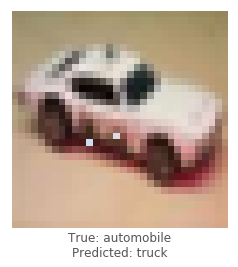

lecun_net - image 5348 - 6 / 10


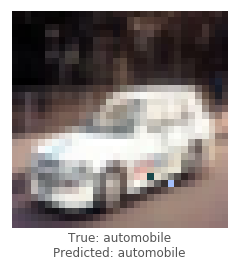

lecun_net - image 205 - 7 / 10


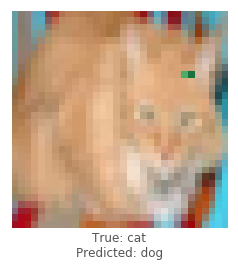

lecun_net - image 5028 - 8 / 10


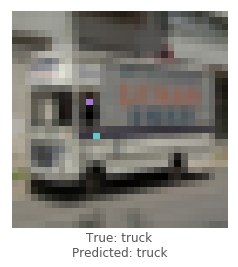

lecun_net - image 8615 - 9 / 10


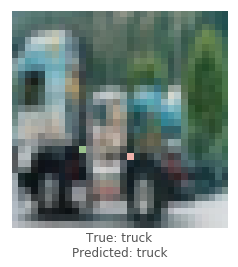

lecun_net - image 1303 - 10 / 10


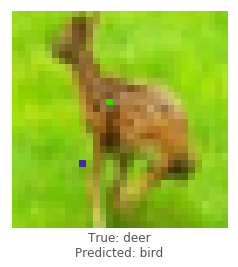

lecun_net - image 9094 - 1 / 10


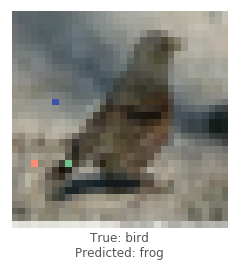

lecun_net - image 8744 - 2 / 10


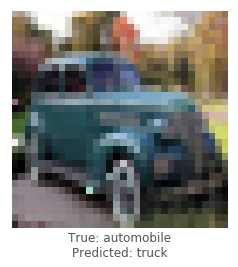

lecun_net - image 2040 - 3 / 10


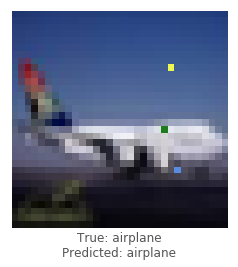

lecun_net - image 5111 - 4 / 10


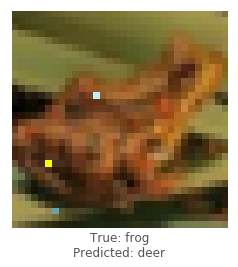

lecun_net - image 3105 - 5 / 10


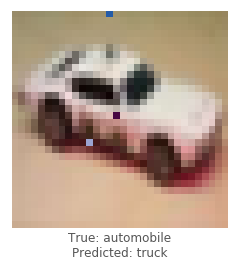

lecun_net - image 5348 - 6 / 10


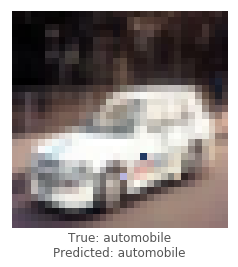

lecun_net - image 205 - 7 / 10


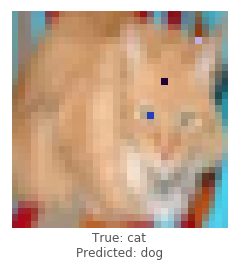

lecun_net - image 5028 - 8 / 10


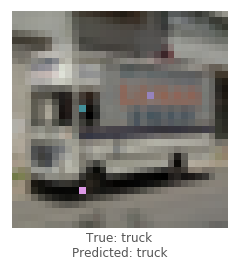

lecun_net - image 8615 - 9 / 10


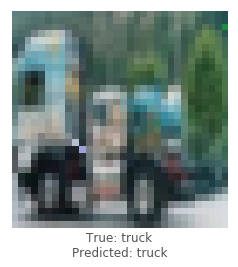

lecun_net - image 1303 - 10 / 10


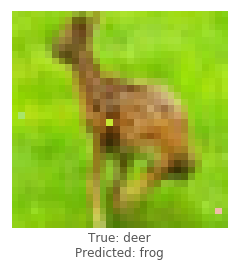

resnet - image 9992 - 1 / 10


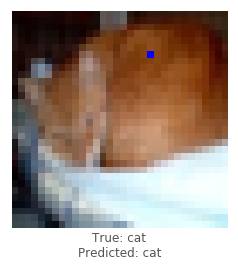

resnet - image 799 - 2 / 10


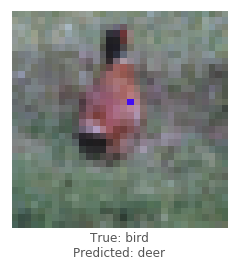

resnet - image 8715 - 3 / 10


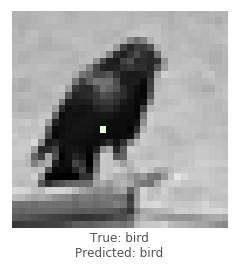

resnet - image 6708 - 4 / 10


/usr/local/lib/python3.5/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


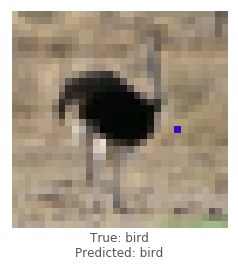

resnet - image 6540 - 5 / 10


In [ ]:
%%time

untargeted = attack_all(models, samples=10, targeted=False)

In [ ]:
%%time
targeted = attack_all(models, samples=10, targeted=True)

### Attack Statistics

In [ ]:
# Save/load our results
# There are precalculated results we can load in this repo
save = True
load = True

if save:
    with open('networks/results/untargeted_results.pkl', 'wb') as file:
        pickle.dump(untargeted, file)
    with open('networks/results/targeted_results.pkl', 'wb') as file:
        pickle.dump(targeted, file)
if load:
    with open('networks/results/untargeted_results.pkl', 'rb') as file:
        untargeted = pickle.load(file)
    with open('networks/results/targeted_results.pkl', 'rb') as file:
        targeted = pickle.load(file)

Print the final results! 

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'attack_image']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
attack_stats(untargeted_results, models, network_stats)

#### Targeted

In [ ]:
attack_stats(targeted_results, models, network_stats)

### Show some successful attacks

Plot 9 random successful attack images

In [ ]:
print('Untargeted Attack')
visualize_attack(untargeted_results, class_names)

In [ ]:
print('Targeted Attack')
visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant to these types of attacks.

These results achieve success rates much lower than described in the academic paper due to a couple reasons:

1. The authors do not provide any source code, so there is no baseline to compare to.
2. This implementation calculates a far smaller population size and uses fewer iterations in the differential evolution algorithm to keep it fast. This is because the differential evolution algorithm is inefficient and could be improved. The `differential_evolution()` function calculates predictions individually instead of batching inputs together. As there's no option to do this in `Scipy`'s implementation, it will need to be rewritten.

TODO: more data necessary for more conclusions!

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar